In [1]:
%matplotlib inline

In [2]:
from src.data import open_ngaqua
import xarray as xr
import xrft


from xgcm import Grid

import numpy as np
import matplotlib.pyplot as plt
plt.style.use('tableau-colorblind10')

fft = np.fft.fft

In [3]:
ngaqua = open_ngaqua()

In [4]:
data_2d = ngaqua.data_2d

u = data_2d['U850']
v = data_2d['V850']

# setup grid
xl = u.x.values
xc = xl + (xl[1]- xl[0])/2

yl = u.y.values
yc = yl + (yl[1]- yl[0])/2
  
u = u.rename({'x': 'xl', 'y': 'yc'}).assign_coords(xl=xl, yc=yc)
v = v.rename({'x': 'xc', 'y': 'yl'}).assign_coords(yl=yl, xc=xc)

# combine the data
ds = xr.Dataset({'u': u, 'v': v}).compute()

# create grid object
coords = {'x': {'center': 'xc', 'left': 'xl'},
          'y': {'center': 'yc', 'left': 'yl'}}
grid = Grid(ds, periodic=['x'], coords=coords)

# use grid to interpolate
uint = grid.interp(ds.u, axis='x')
vint = grid.interp(ds.v, axis='y', boundary='extend')

# compute the power spectra
uiso2 = xrft.isotropic_powerspectrum(uint, dim=['xc','yc'], nfactor=10).compute()
viso2 = xrft.isotropic_powerspectrum(vint, dim=['xc','yc'], nfactor=10).compute()
ekeiso = .5*(uiso2 + viso2)

/miniconda/lib/python3.7/site-packages/xrft/xrft.py:589: RuntimeWarning: invalid value encountered in true_divide
  kr = np.bincount(kidx, weights=K.ravel()) / area
/miniconda/lib/python3.7/site-packages/xrft/xrft.py:599: RuntimeWarning: invalid value encountered in true_divide
  / area) * kr


/miniconda/lib/python3.7/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


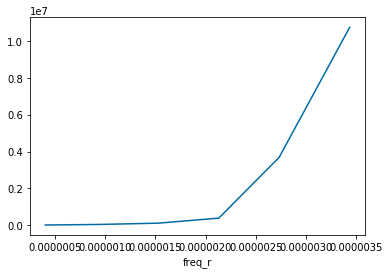

In [5]:
ekeiso.mean('time').plot()

This result makes no sense. Why is the power increasing with frequency? I am just going to do it myself.

In [6]:
dim = 'xc'
avg = ['yc' ,'time']
dim_vals = ds[dim].values

d = dim_vals[1] - dim_vals[0]

fu = fft(uint, axis=uint.get_axis_num(dim)).mean(uint.get_axis_num(avg))
fv = fft(vint, axis=vint.get_axis_num(dim)).mean(vint.get_axis_num(avg))

pw = (np.abs(fu)**2 + np.abs(fv)**2)/2
k = np.fft.fftfreq(n=len(fu), d=d)

k, pw = k[k>=0], pw[k>=0]

(1.714090436754794e-05, 3162.2776601683795)

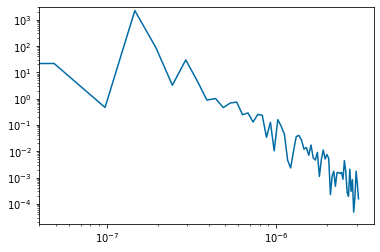

In [7]:
plt.loglog(k, pw)
plt.ylim(top=10**3.5)

In [8]:
from uwnet.spectrum import *

In [9]:
pw = kinetic_energy_spectrum_staggered(data_2d.U850, data_2d.V850)

/miniconda/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 256 is greater than input length  = 128, using nperseg = 128
  .format(nperseg, input_length))


Text(0.5, 0, 'Horizontal Frequency (1/m)')

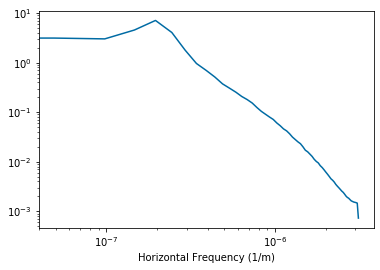

In [10]:
plt.loglog(pw.freq_x, pw)
plt.xlabel('Horizontal Frequency (1/m)')

# Plot Spectra for Stable and NG-Aqua

In [11]:
from src.data import runs

time_range = slice(104, 106)

def ke_spectra_850(case):
    data_2d = case.data_2d.sel(time=time_range)
    return kinetic_energy_spectrum_staggered(data_2d.U850, data_2d.V850)

def ke_spectra_200(case):
    data_2d = case.data_2d.sel(time=time_range)
    return kinetic_energy_spectrum_staggered(data_2d.U200, data_2d.V200)

def pw_spectra(case):
    data_2d = case.data_2d.sel(time=time_range)
    return horizontal_power_spectrum(data_2d['PW'], dim='x', avg=['y', 'time'])


runs_for_ke_plot = {'NGAqua': ngaqua, '$K_4=10^{16}$': runs['debias'], '$K_4=10^{15}$': runs['khyp1e15']}

pw850 = xr.Dataset({name: ke_spectra_850(run) for name, run in runs_for_ke_plot.items()}) 
pw200 = xr.Dataset({name: ke_spectra_200(run) for name, run in runs_for_ke_plot.items()})

/miniconda/lib/python3.7/site-packages/pandas/plotting/_core.py:1001: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_xlim(left, right)


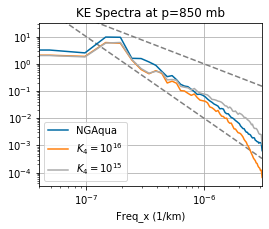

In [12]:
def plot_ke_spec(pw, top=10**(1.5)):
    fig, ax = plt.subplots(figsize=(4,3))
    plt.loglog(pw.freq_x, pw.freq_x**(-3)/10**(20), c='0.5', ls='--')
    plt.loglog(pw.freq_x, pw.freq_x**(-5/3)/10**(10), c='0.5', ls='--')
    pw.to_dataframe().plot(logx=True, logy=True, ax=ax)
    plt.grid()
    plt.xlabel('Freq_x (1/km)')
    plt.ylim(top=top)
    
plot_ke_spec(pw850) 
plt.title("KE Spectra at p=850 mb");

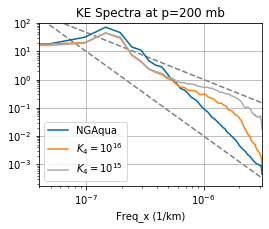

In [13]:
plot_ke_spec(pw200, top=1e2) 
plt.title("KE Spectra at p=200 mb");